In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Load dataset
df = pd.read_csv(r"C:\Users\FAUZAN\Downloads\DailyDelhiClimateTest.csv")
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


# what exactly is ARIMA? 
# It’s basically a mix of three things:

# AutoRegressive (AR) – Using past values to predict the future
# Integrated (I) – Differencing to remove trends and make data stationary
# Moving Average (MA) – Smoothing out noise using past forecast errors
# The model is written as ARIMA(p, d, q), where:

# p = Number of past values to consider (AR order)
# d = How many times we difference the data (Integration order)
# q = How much past noise we consider (MA order)

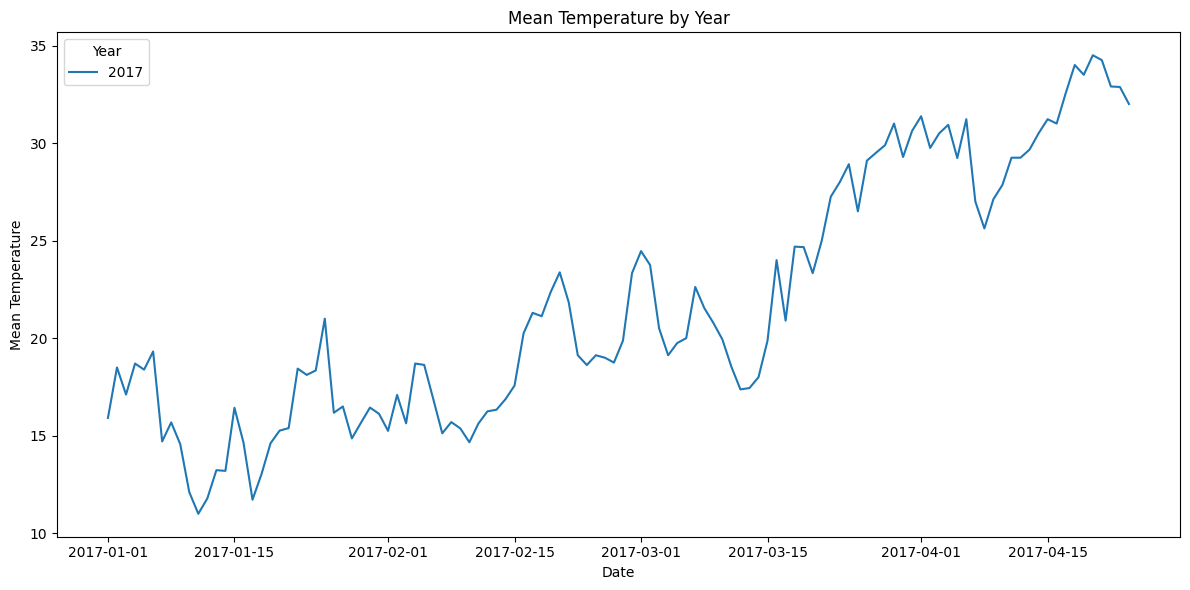

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure 'date' is datetime
df['date'] = pd.to_datetime(df['date'])

# Extract year
df['year'] = df['date'].dt.year

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each year separately
for year in sorted(df['year'].unique()):
    yearly_data = df[df['year'] == year]
    sns.lineplot(x=yearly_data['date'], y=yearly_data['meantemp'], label=str(year))

plt.title("Mean Temperature by Year")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend(title='Year')
plt.tight_layout()
plt.show()


<Axes: >

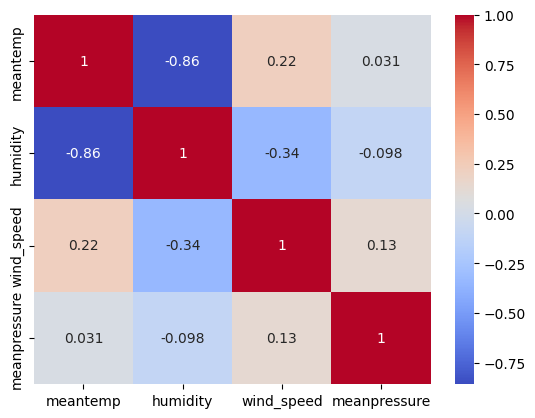

In [3]:
sns.heatmap(df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].corr(), annot=True, cmap='coolwarm')


# Checking for Stationarity
# A stationary time series is one where the statistical properties don’t change over time. Let’s test that:
# If p-value > 0.05, then data isn’t stationary. 
# Time to difference it!

In [4]:
result = adfuller(df['meantemp'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.096474275875619
p-value: 0.7164758731775932


# As p-value is greater than 0.5, Doing first order differencing to Achieve Stationarity

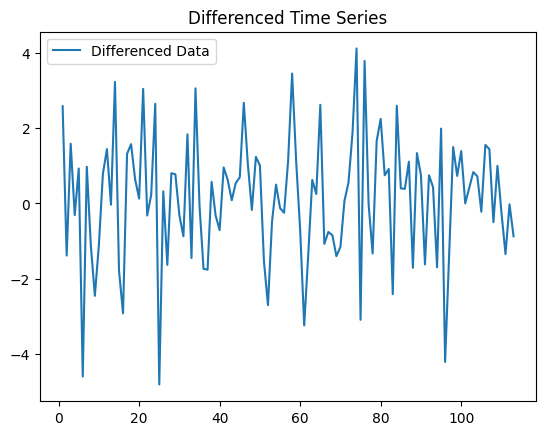

In [5]:
df['Differenced'] = df['meantemp'].diff().dropna()
plt.plot(df['Differenced'], label='Differenced Data')
plt.title("Differenced Time Series")
plt.legend()
plt.show()

# Now Identifying Model Parameters (p, d, q)
# Choosing p, d, and q can feel like picking lottery numbers, but it’s actually a bit more scientific. We use autocorrelation and partial autocorrelation plots:

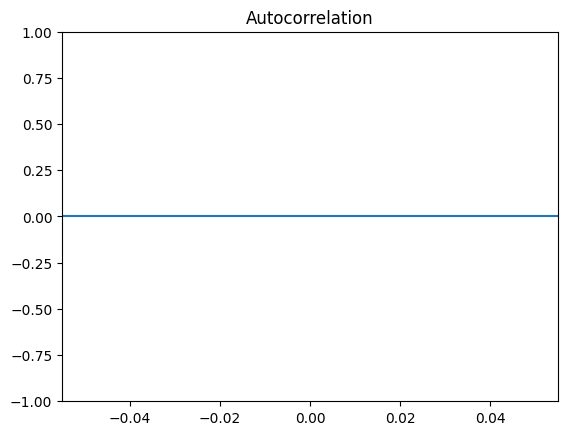

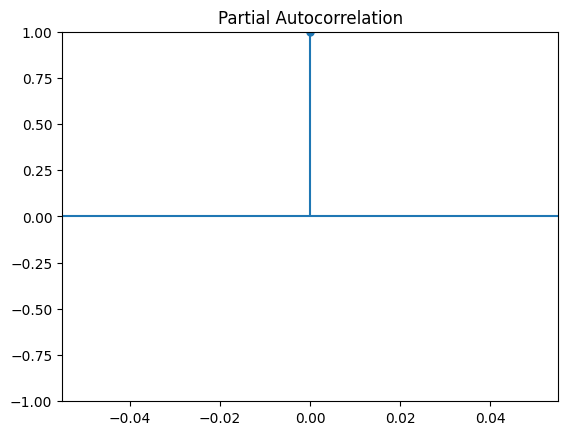

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Differenced'])
plot_pacf(df['Differenced'])
plt.show()

# Fitting the ARIMA Model

In [7]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['meantemp'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                  114
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -218.781
Date:                Sat, 31 May 2025   AIC                            443.562
Time:                        14:10:54   BIC                            451.744
Sample:                             0   HQIC                           446.882
                                - 114                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1196      0.831     -0.144      0.886      -1.749       1.510
ma.L1         -0.0034      0.854     -0.004      0.997      -1.676       1.670
sigma2         2.8129      0.362      7.769      0.0

#  Evaluating Model Performance

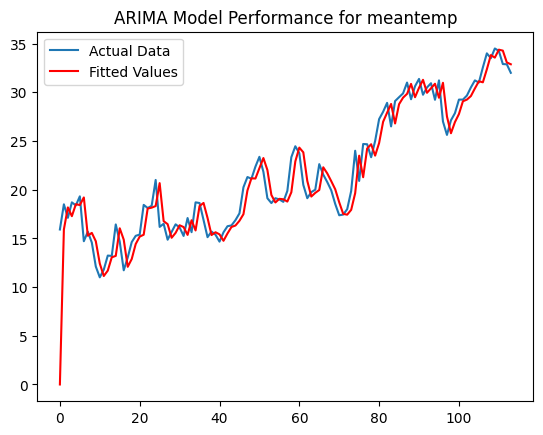

In [8]:
plt.plot(df['meantemp'], label='Actual Data')
plt.plot(model_fit.fittedvalues, label='Fitted Values', color='red')
plt.legend()
plt.title("ARIMA Model Performance for meantemp")
plt.show()

# Forecasting Future Values of 15 days 

In [9]:
forecast = model_fit.forecast(steps=15)
print(forecast)

114    32.107680
115    32.094800
116    32.096340
117    32.096156
118    32.096178
119    32.096175
120    32.096176
121    32.096176
122    32.096176
123    32.096176
124    32.096176
125    32.096176
126    32.096176
127    32.096176
128    32.096176
Name: predicted_mean, dtype: float64


 # performing a grid search to identify the best ARIMA model for forecasting the meantemp (mean temperature) time series based on Mean Squared Error (MSE).
# where: 

# ARIMA(p, d, q) is a forecasting model with 3 key parameters:

# p: Number of autoregressive (AR) terms (uses past values)

# d: Number of differencing operations to make the data stationary

# q: Number of moving average (MA) terms (uses past forecast errors)

# then Selecting the best one for accurate forecasting



In [10]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Set the series (e.g. mean temperature)
series = df['meantemp'].dropna()

# Grid search
best_score, best_cfg = float("inf"), None
warnings.filterwarnings("ignore")

for p in range(0, 4):      # try p = 0 to 3
    for d in range(0, 3):  # try d = 0 to 2
        for q in range(0, 4):  # try q = 0 to 3
            try:
                model = ARIMA(series, order=(p,d,q))
                model_fit = model.fit()
                mse = mean_squared_error(series[d:], model_fit.fittedvalues[d:])
                if mse < best_score:
                    best_score, best_cfg = mse, (p,d,q)
                print(f'ARIMA{(p,d,q)} MSE={mse:.3f}')
            except:
                continue

print(f'\nBest ARIMA config for mean temperature : {best_cfg} with MSE={best_score:.3f}')


ARIMA(0, 0, 0) MSE=40.096
ARIMA(0, 0, 1) MSE=14.719
ARIMA(0, 0, 2) MSE=8.949
ARIMA(0, 0, 3) MSE=6.189
ARIMA(0, 1, 0) MSE=2.856
ARIMA(0, 1, 1) MSE=2.814
ARIMA(0, 1, 2) MSE=2.814
ARIMA(0, 1, 3) MSE=2.813
ARIMA(0, 2, 0) MSE=6.395
ARIMA(0, 2, 1) MSE=3.055
ARIMA(0, 2, 2) MSE=3.015
ARIMA(0, 2, 3) MSE=3.013
ARIMA(1, 0, 0) MSE=3.176
ARIMA(1, 0, 1) MSE=3.169
ARIMA(1, 0, 2) MSE=3.157
ARIMA(1, 0, 3) MSE=3.153
ARIMA(1, 1, 0) MSE=2.814
ARIMA(1, 1, 1) MSE=2.814
ARIMA(1, 1, 2) MSE=2.814
ARIMA(1, 1, 3) MSE=2.814
ARIMA(1, 2, 0) MSE=4.456
ARIMA(1, 2, 1) MSE=3.013
ARIMA(1, 2, 2) MSE=3.013
ARIMA(1, 2, 3) MSE=3.008
ARIMA(2, 0, 0) MSE=3.166
ARIMA(2, 0, 1) MSE=3.165
ARIMA(2, 0, 2) MSE=3.169
ARIMA(2, 0, 3) MSE=3.136
ARIMA(2, 1, 0) MSE=2.814
ARIMA(2, 1, 1) MSE=2.814
ARIMA(2, 1, 2) MSE=2.790
ARIMA(2, 1, 3) MSE=2.785
ARIMA(2, 2, 0) MSE=3.843
ARIMA(2, 2, 1) MSE=3.013
ARIMA(2, 2, 2) MSE=3.006
ARIMA(2, 2, 3) MSE=2.895
ARIMA(3, 0, 0) MSE=3.163
ARIMA(3, 0, 1) MSE=3.162
ARIMA(3, 0, 2) MSE=3.014
ARIMA(3, 0, 3) MSE=3.00

# found out that ARIMA config for mean temp stands at (3,1,3)

# 2 for humidity feature

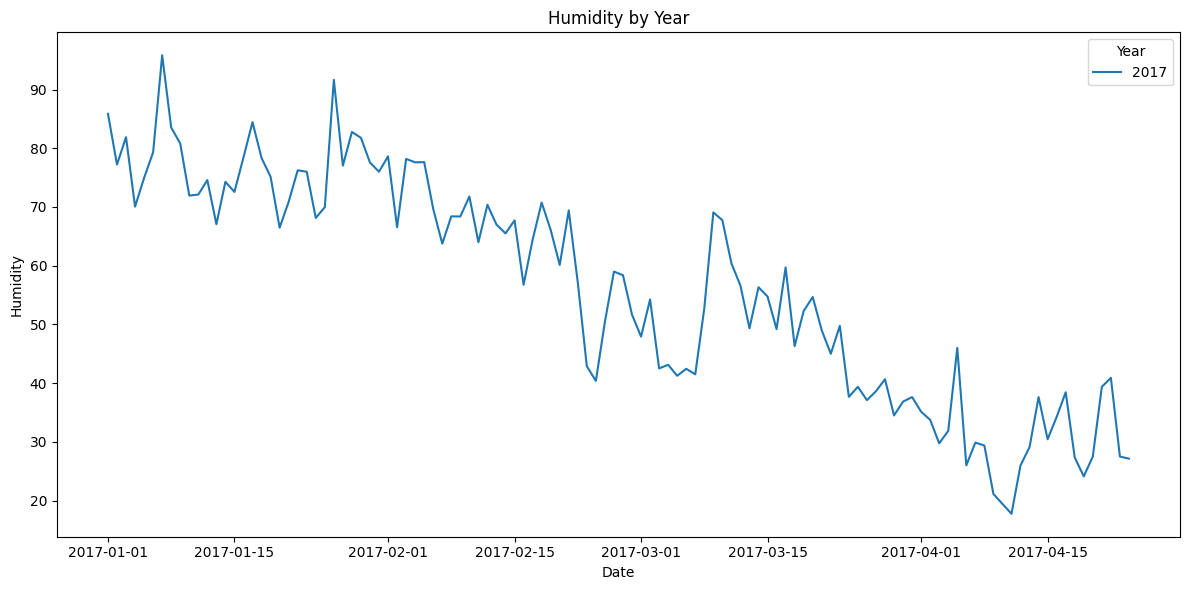

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure 'date' is datetime
df['date'] = pd.to_datetime(df['date'])

# Extract year
df['year'] = df['date'].dt.year

# Create the plot
plt.figure(figsize=(12, 6))

# Plot humidity for each year separately
for year in sorted(df['year'].unique()):
    yearly_data = df[df['year'] == year]
    sns.lineplot(x=yearly_data['date'], y=yearly_data['humidity'], label=str(year))

plt.title("Humidity by Year")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend(title='Year')
plt.tight_layout()
plt.show()


# Checking for Stationarity
# A stationary time series is one where the statistical properties don’t change over time. Let’s test that:
# If p-value > 0.05, then data isn’t stationary. 
# Time to difference it!

In [12]:
result = adfuller(df['humidity'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -0.6757281773610543
p-value: 0.852936721999241


# As p-value is greater than 0.5, Doing first order differencing to Achieve Stationarity

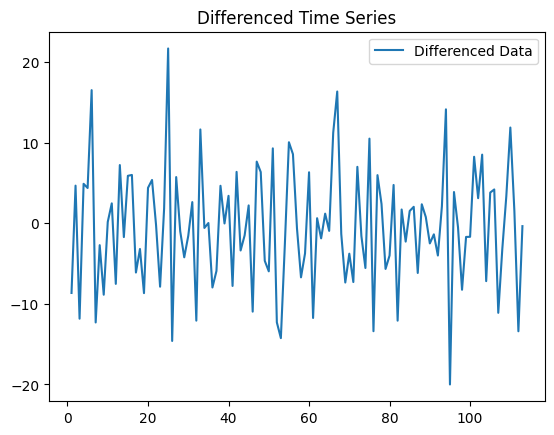

In [13]:
df['Differenced'] = df['humidity'].diff().dropna()
plt.plot(df['Differenced'], label='Differenced Data')
plt.title("Differenced Time Series")
plt.legend()
plt.show()

# Now Identifying Model Parameters (p, d, q)


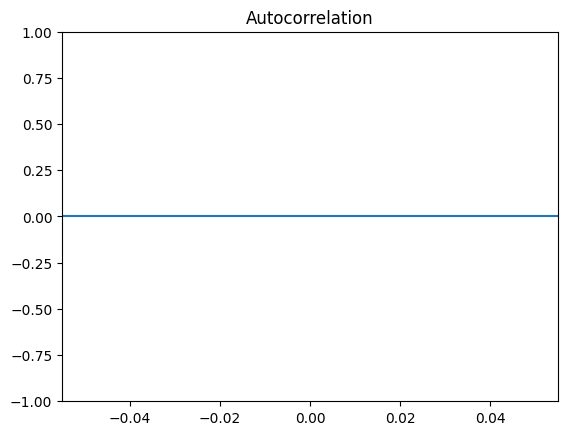

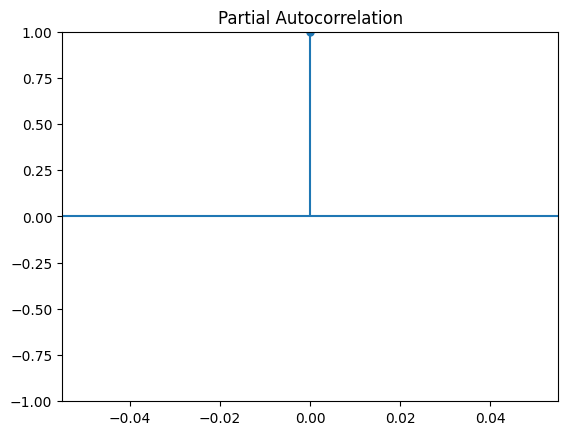

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Differenced'])
plot_pacf(df['Differenced'])
plt.show()

# Fitting the ARIMA Model

In [15]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['humidity'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               humidity   No. Observations:                  114
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -378.377
Date:                Sat, 31 May 2025   AIC                            762.754
Time:                        14:11:02   BIC                            770.937
Sample:                             0   HQIC                           766.075
                                - 114                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4010      0.141      2.846      0.004       0.125       0.677
ma.L1         -0.7794      0.111     -7.005      0.000      -0.998      -0.561
sigma2        47.2698      5.922      7.981      0.0

#  Evaluating Model Performance

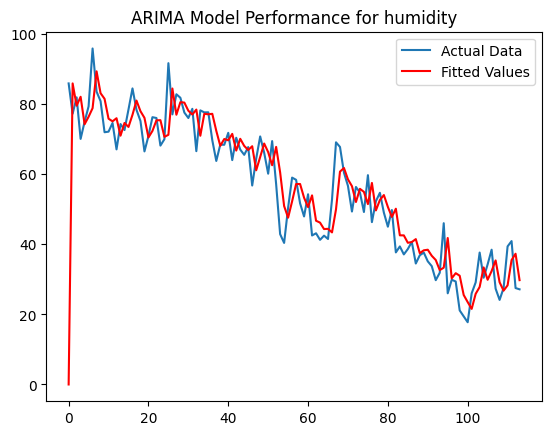

In [16]:
plt.plot(df['humidity'], label='Actual Data')
plt.plot(model_fit.fittedvalues, label='Fitted Values', color='red')
plt.legend()
plt.title("ARIMA Model Performance for humidity")
plt.show()

# Forecasting Future Values of 15 days 

In [17]:
forecast = model_fit.forecast(steps=15)
print(forecast)

114    29.037392
115    29.797099
116    30.101741
117    30.223902
118    30.272889
119    30.292532
120    30.300409
121    30.303568
122    30.304834
123    30.305342
124    30.305546
125    30.305628
126    30.305660
127    30.305674
128    30.305679
Name: predicted_mean, dtype: float64


 # performing a grid search to identify the best ARIMA model for forecasting the meantemp (mean temperature) time series based on Mean Squared Error (MSE).
# where: 

# ARIMA(p, d, q) is a forecasting model with 3 key parameters:

# p: Number of autoregressive (AR) terms (uses past values)

# d: Number of differencing operations to make the data stationary

# q: Number of moving average (MA) terms (uses past forecast errors)

# then Selecting the best one for accurate forecasting



In [18]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Set the series (e.g. humidity)
series = df['humidity'].dropna()

# Grid search for ARIMA(p,d,q)
best_score, best_cfg = float("inf"), None
warnings.filterwarnings("ignore")

for p in range(0, 4):      # try p = 0 to 3
    for d in range(0, 3):  # try d = 0 to 2
        for q in range(0, 4):  # try q = 0 to 3
            try:
                model = ARIMA(series, order=(p, d, q))
                model_fit = model.fit()
                
                # Important: align forecast and true series by skipping first d values
                fitted_vals = model_fit.fittedvalues
                mse = mean_squared_error(series[d:], fitted_vals[d:])
                
                if mse < best_score:
                    best_score, best_cfg = mse, (p, d, q)
                print(f'ARIMA{(p,d,q)} MSE={mse:.3f}')
            except:
                continue

print(f'\nBest ARIMA config for Humidity feature: {best_cfg} with MSE={best_score:.3f}')


ARIMA(0, 0, 0) MSE=360.402
ARIMA(0, 0, 1) MSE=160.242
ARIMA(0, 0, 2) MSE=112.285
ARIMA(0, 0, 3) MSE=88.791
ARIMA(0, 1, 0) MSE=55.377
ARIMA(0, 1, 1) MSE=50.310
ARIMA(0, 1, 2) MSE=47.754
ARIMA(0, 1, 3) MSE=47.312
ARIMA(0, 2, 0) MSE=137.687
ARIMA(0, 2, 1) MSE=58.933
ARIMA(0, 2, 2) MSE=53.868
ARIMA(0, 2, 3) MSE=51.084
ARIMA(1, 0, 0) MSE=60.470
ARIMA(1, 0, 1) MSE=56.788
ARIMA(1, 0, 2) MSE=54.578
ARIMA(1, 0, 3) MSE=54.181
ARIMA(1, 1, 0) MSE=52.236
ARIMA(1, 1, 1) MSE=47.462
ARIMA(1, 1, 2) MSE=47.400
ARIMA(1, 1, 3) MSE=47.307
ARIMA(1, 2, 0) MSE=95.594
ARIMA(1, 2, 1) MSE=55.697
ARIMA(1, 2, 2) MSE=49.996
ARIMA(1, 2, 3) MSE=52.704
ARIMA(2, 0, 0) MSE=58.161
ARIMA(2, 0, 1) MSE=54.356
ARIMA(2, 0, 2) MSE=54.331
ARIMA(2, 0, 3) MSE=54.190
ARIMA(2, 1, 0) MSE=50.691
ARIMA(2, 1, 1) MSE=47.377
ARIMA(2, 1, 2) MSE=47.443
ARIMA(2, 1, 3) MSE=46.710
ARIMA(2, 2, 0) MSE=81.720
ARIMA(2, 2, 1) MSE=54.377
ARIMA(2, 2, 2) MSE=54.658
ARIMA(2, 2, 3) MSE=57.672
ARIMA(3, 0, 0) MSE=56.961
ARIMA(3, 0, 1) MSE=54.239
ARIMA(3,

# found out that ARIMA config for mean temp stands at (3,1,3)

# 3 wind speed feature

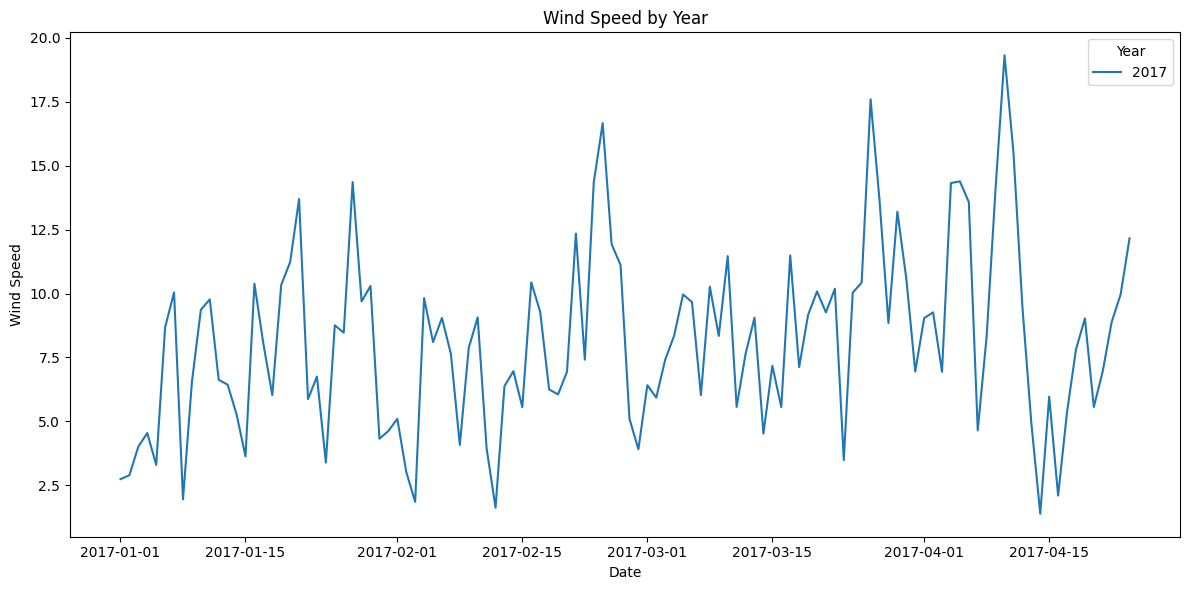

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure 'date' is datetime
df['date'] = pd.to_datetime(df['date'])

# Extract year
df['year'] = df['date'].dt.year

# Create the plot
plt.figure(figsize=(12, 6))

# Plot wind_speed for each year separately
for year in sorted(df['year'].unique()):
    yearly_data = df[df['year'] == year]
    sns.lineplot(x=yearly_data['date'], y=yearly_data['wind_speed'], label=str(year))

plt.title("Wind Speed by Year")
plt.xlabel("Date")
plt.ylabel("Wind Speed")
plt.legend(title='Year')
plt.tight_layout()
plt.show()


# Checking for Stationarity
# A stationary time series is one where the statistical properties don’t change over time. Let’s test that:
# If p-value > 0.05, then data isn’t stationary. 
# Time to difference it!

In [20]:
result = adfuller(df['wind_speed'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -6.51805527766912
p-value: 1.059089329399316e-08


# As p-value is greater than 0.5, Doing first order differencing to Achieve Stationarity

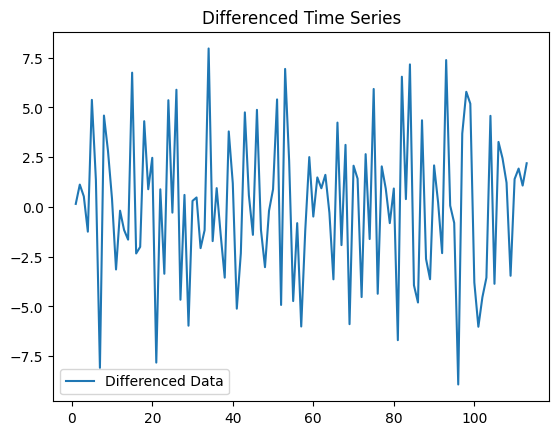

In [21]:
df['Differenced'] = df['wind_speed'].diff().dropna()
plt.plot(df['Differenced'], label='Differenced Data')
plt.title("Differenced Time Series")
plt.legend()
plt.show()

# Now Identifying Model Parameters (p, d, q)


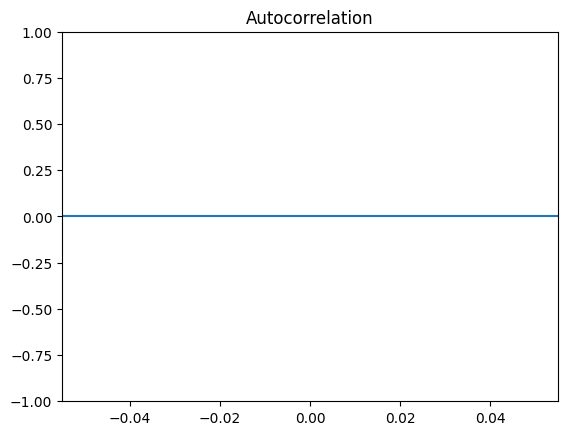

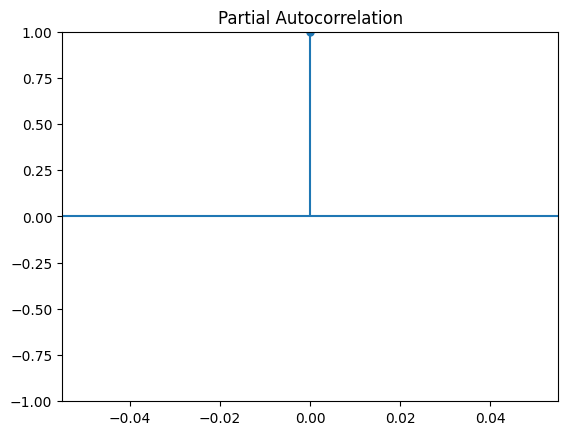

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Differenced'])
plot_pacf(df['Differenced'])
plt.show()

# Fitting the ARIMA Model

In [23]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['wind_speed'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             wind_speed   No. Observations:                  114
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -293.076
Date:                Sat, 31 May 2025   AIC                            592.151
Time:                        14:11:10   BIC                            600.333
Sample:                             0   HQIC                           595.471
                                - 114                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4355      0.097      4.490      0.000       0.245       0.626
ma.L1         -0.9658      0.029    -33.050      0.000      -1.023      -0.908
sigma2        10.3111      1.455      7.086      0.0

#  Evaluating Model Performance

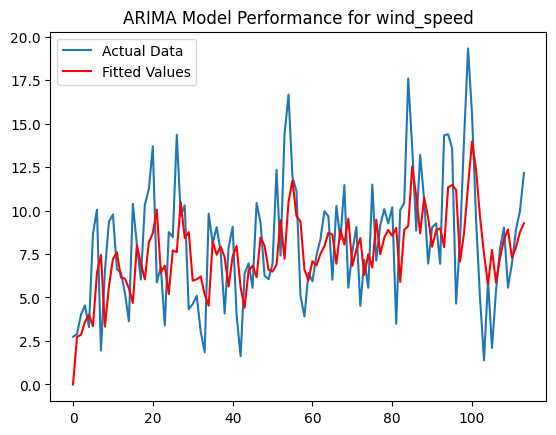

In [24]:
plt.plot(df['wind_speed'], label='Actual Data')
plt.plot(model_fit.fittedvalues, label='Fitted Values', color='red')
plt.legend()
plt.title("ARIMA Model Performance for wind_speed")
plt.show()

# Forecasting Future Values of 15 days 

In [25]:
forecast = model_fit.forecast(steps=15)
print(forecast)

114    10.315972
115     9.514157
116     9.164972
117     9.012905
118     8.946681
119     8.917841
120     8.905281
121     8.899811
122     8.897429
123     8.896392
124     8.895940
125     8.895744
126     8.895658
127     8.895621
128     8.895604
Name: predicted_mean, dtype: float64


 # performing a grid search to identify the best ARIMA model for forecasting the meantemp (mean temperature) time series based on Mean Squared Error (MSE).
# where: 

# ARIMA(p, d, q) is a forecasting model with 3 key parameters:

# p: Number of autoregressive (AR) terms (uses past values)

# d: Number of differencing operations to make the data stationary

# q: Number of moving average (MA) terms (uses past forecast errors)

# then Selecting the best one for accurate forecasting



In [26]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Set the series (e.g. wind_speed)
series = df['wind_speed'].dropna()

# Grid search for ARIMA(p,d,q)
best_score, best_cfg = float("inf"), None
warnings.filterwarnings("ignore")

for p in range(0, 4):      # try p = 0 to 3
    for d in range(0, 3):  # try d = 0 to 2
        for q in range(0, 4):  # try q = 0 to 3
            try:
                model = ARIMA(series, order=(p, d, q))
                model_fit = model.fit()
                
                # Align forecast and actual series
                fitted_vals = model_fit.fittedvalues
                mse = mean_squared_error(series[d:], fitted_vals[d:])
                
                if mse < best_score:
                    best_score, best_cfg = mse, (p, d, q)
                print(f'ARIMA{(p,d,q)} MSE={mse:.3f}')
            except:
                continue

print(f'\nBest ARIMA config for Wind Speed feature: {best_cfg} with MSE={best_score:.3f}')


ARIMA(0, 0, 0) MSE=12.761
ARIMA(0, 0, 1) MSE=10.642
ARIMA(0, 0, 2) MSE=10.058
ARIMA(0, 0, 3) MSE=10.057
ARIMA(0, 1, 0) MSE=13.868
ARIMA(0, 1, 1) MSE=12.232
ARIMA(0, 1, 2) MSE=10.744
ARIMA(0, 1, 3) MSE=10.273
ARIMA(0, 2, 0) MSE=35.263
ARIMA(0, 2, 1) MSE=14.481
ARIMA(0, 2, 2) MSE=12.851
ARIMA(0, 2, 3) MSE=11.447
ARIMA(1, 0, 0) MSE=10.196
ARIMA(1, 0, 1) MSE=10.194
ARIMA(1, 0, 2) MSE=10.056
ARIMA(1, 0, 3) MSE=10.055
ARIMA(1, 1, 0) MSE=12.915
ARIMA(1, 1, 1) MSE=10.429
ARIMA(1, 1, 2) MSE=10.423
ARIMA(1, 1, 3) MSE=10.261
ARIMA(1, 2, 0) MSE=23.361
ARIMA(1, 2, 1) MSE=13.495
ARIMA(1, 2, 2) MSE=11.088
ARIMA(1, 2, 3) MSE=11.086
ARIMA(2, 0, 0) MSE=10.193
ARIMA(2, 0, 1) MSE=10.184
ARIMA(2, 0, 2) MSE=10.054
ARIMA(2, 0, 3) MSE=10.053
ARIMA(2, 1, 0) MSE=12.674
ARIMA(2, 1, 1) MSE=10.418
ARIMA(2, 1, 2) MSE=10.427
ARIMA(2, 1, 3) MSE=10.261
ARIMA(2, 2, 0) MSE=20.930
ARIMA(2, 2, 1) MSE=13.241
ARIMA(2, 2, 2) MSE=13.454
ARIMA(2, 2, 3) MSE=13.521
ARIMA(3, 0, 0) MSE=10.076
ARIMA(3, 0, 1) MSE=10.067
ARIMA(3, 0, 

# found out that ARIMA config for mean temp stands at (3,0,3)

# 4 for meanpressure feature

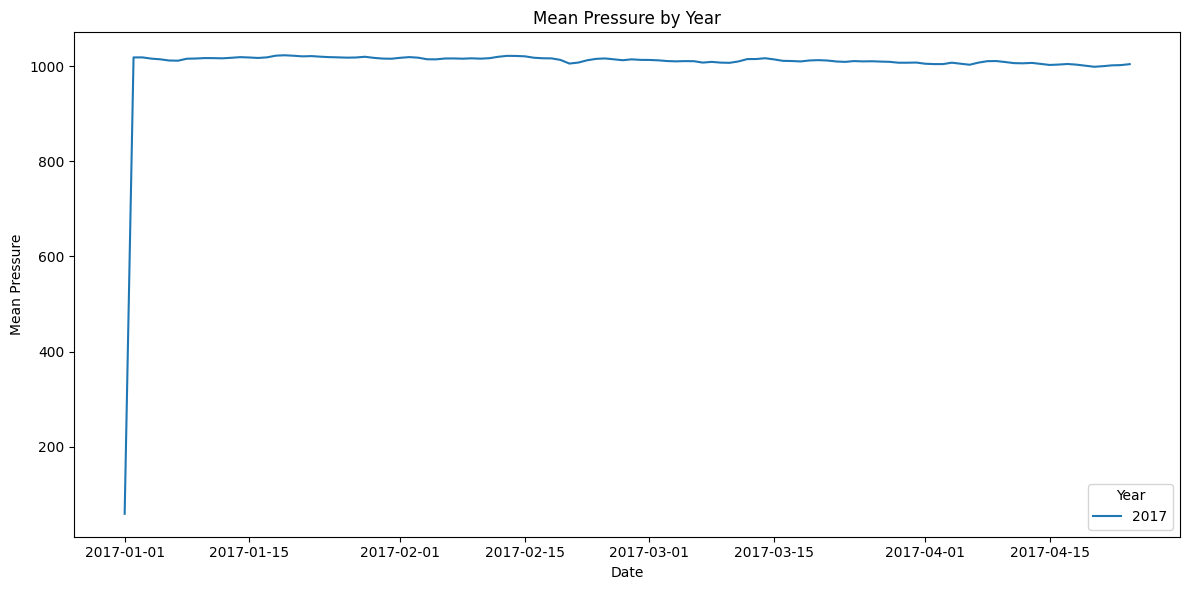

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure 'date' is datetime
df['date'] = pd.to_datetime(df['date'])

# Extract year
df['year'] = df['date'].dt.year

# Create the plot
plt.figure(figsize=(12, 6))

# Plot meanpressure for each year separately
for year in sorted(df['year'].unique()):
    yearly_data = df[df['year'] == year]
    sns.lineplot(x=yearly_data['date'], y=yearly_data['meanpressure'], label=str(year))

plt.title("Mean Pressure by Year")
plt.xlabel("Date")
plt.ylabel("Mean Pressure")
plt.legend(title='Year')
plt.tight_layout()
plt.show()


# Checking for Stationarity
# A stationary time series is one where the statistical properties don’t change over time. Let’s test that:
# If p-value > 0.05, then data isn’t stationary. 
# Time to difference it!

In [28]:
result = adfuller(df['meanpressure'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.1822196938171645
p-value: 0.21276185166800982


# As p-value is less than 0.5, No need to do first order differencing to Achieve Stationarity, directly fitting ARIMA model

In [29]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['meanpressure'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           meanpressure   No. Observations:                  114
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -669.147
Date:                Sat, 31 May 2025   AIC                           1344.293
Time:                        14:11:16   BIC                           1352.475
Sample:                             0   HQIC                          1347.613
                                - 114                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9822     65.428      0.015      0.988    -127.255     129.219
ma.L1         -0.9827     64.396     -0.015      0.988    -127.196     125.231
sigma2      8143.2909    256.752     31.717      0.0

# Now Identifying Model Parameters (p, d, q)


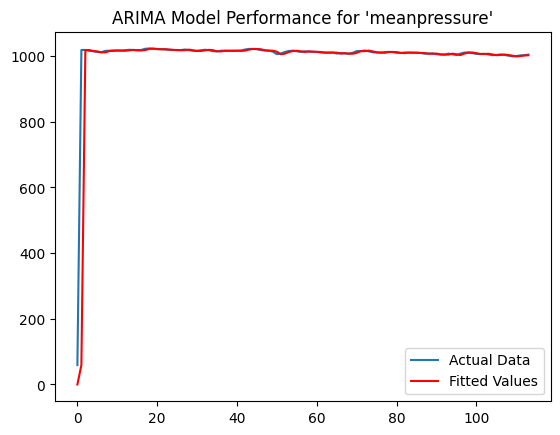

In [30]:
plt.plot(df['meanpressure'], label='Actual Data')
plt.plot(model_fit.fittedvalues, label='Fitted Values', color='red')
plt.legend()
plt.title("ARIMA Model Performance for 'meanpressure'")
plt.show()

# Fitting the ARIMA Model

In [31]:
forecast = model_fit.forecast(steps=15)
print(forecast)

114    1004.074202
115    1004.006771
116    1003.940542
117    1003.875494
118    1003.811606
119    1003.748858
120    1003.687227
121    1003.626696
122    1003.567244
123    1003.508852
124    1003.451502
125    1003.395174
126    1003.339850
127    1003.285512
128    1003.232144
Name: predicted_mean, dtype: float64


 # performing a grid search to identify the best ARIMA model for forecasting the meantemp (mean temperature) time series based on Mean Squared Error (MSE).
# where: 

# ARIMA(p, d, q) is a forecasting model with 3 key parameters:

# p: Number of autoregressive (AR) terms (uses past values)

# d: Number of differencing operations to make the data stationary

# q: Number of moving average (MA) terms (uses past forecast errors)

# then Selecting the best one for accurate forecasting



In [32]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Set the series to meanpressure
series = df['meanpressure'].dropna()

# Grid search for ARIMA(p,d,q)
best_score, best_cfg = float("inf"), None
warnings.filterwarnings("ignore")

for p in range(0, 4):      # try p = 0 to 3
    for d in range(0, 3):  # try d = 0 to 2
        for q in range(0, 4):  # try q = 0 to 3
            try:
                model = ARIMA(series, order=(p, d, q))
                model_fit = model.fit()
                
                # Align forecast and actual series
                fitted_vals = model_fit.fittedvalues
                mse = mean_squared_error(series[d:], fitted_vals[d:])
                
                if mse < best_score:
                    best_score, best_cfg = mse, (p, d, q)
                print(f'ARIMA{(p,d,q)} MSE={mse:.3f}')
            except:
                continue

print(f'\nBest ARIMA config for Mean Pressure feature: {best_cfg} with MSE={best_score:.3f}')


ARIMA(0, 0, 0) MSE=7935.495
ARIMA(0, 0, 1) MSE=8279.101
ARIMA(0, 0, 2) MSE=8167.701
ARIMA(0, 0, 3) MSE=16635.163
ARIMA(0, 1, 0) MSE=8147.192
ARIMA(0, 1, 1) MSE=8172.552
ARIMA(0, 1, 2) MSE=8396.810
ARIMA(0, 1, 3) MSE=18783.377
ARIMA(0, 2, 0) MSE=8220.861
ARIMA(0, 2, 1) MSE=10068.210
ARIMA(0, 2, 2) MSE=9618.557
ARIMA(0, 2, 3) MSE=18196.026
ARIMA(1, 0, 0) MSE=8200.795
ARIMA(1, 0, 1) MSE=8128.086
ARIMA(1, 0, 2) MSE=8130.352
ARIMA(1, 0, 3) MSE=8129.303
ARIMA(1, 1, 0) MSE=8158.806
ARIMA(1, 1, 1) MSE=8147.215
ARIMA(1, 1, 2) MSE=8172.695
ARIMA(1, 1, 3) MSE=11522.126
ARIMA(1, 2, 0) MSE=9189.491
ARIMA(1, 2, 1) MSE=9722.808
ARIMA(1, 2, 2) MSE=13153.537
ARIMA(1, 2, 3) MSE=20331.302
ARIMA(2, 0, 0) MSE=8228.682
ARIMA(2, 0, 1) MSE=8198.539
ARIMA(2, 0, 2) MSE=8128.121
ARIMA(2, 0, 3) MSE=8573.325
ARIMA(2, 1, 0) MSE=8348.924
ARIMA(2, 1, 1) MSE=8159.235
ARIMA(2, 1, 2) MSE=8147.501
ARIMA(2, 1, 3) MSE=8172.029
ARIMA(2, 2, 0) MSE=9588.188
ARIMA(2, 2, 1) MSE=9188.014
ARIMA(2, 2, 2) MSE=8221.095
ARIMA(2, 2, 3

# found out that ARIMA config for Mean Pressure stands at (0, 0, 0)